# Thetis Accelerometer Validation
This notebook will compare the measured accelerations captured by a reference accelerometer to that of the Thetis accelerometer using several statistical metrics.

The waveform generator will create a sinusoidal waveform at a given frequency, f, (maximum 20 Hz) that is sent to the amplifier. The amplifier then converts that to a signal that drives the vibration table at a higher amplitude.

At lower frequencies, the vibration table is unable to generate a clean sine wave signal. Therefore, another accelerometer of known calibration was attached to the vibration table in the axis of movement to act as a ground truth reference. It is this ground truth that will be compared with the Thetis data to validate the instrument.
Data is recorded from the accelerometer using the oscilloscope. These data files are saved as CSVs that can be plotted alongside the Thetis data.

### CHANGELOG:
 - Version 1.0: Initial Release
 - Version 2.0: Revamped to account for new testing procedure

### TODO:
 - 

In [18]:
# Import libraries and declare constants
from ctypes import sizeof
from util import ThetisData, read_oscilloscope_data
import matplotlib.pyplot as plt
import datetime as dt
from math import pi
import numpy as np
import pandas as pd
from scipy import signal

# Constants and measurements
SCOPE_OFFSET = -7.22        # Oscilloscope voltage measurement offset - V
ACCELEROMETER_SCALE = 0.115 	# Measured value per g of acceleration by the accelerometer - V/g
SCALE_FACTOR = 9.81 / ACCELEROMETER_SCALE # Convert oscilloscope voltage measurements to accelerations - m/s/s / V

# CHANGE THIS BEN!!!
CURRENT_DATASET = "x" # x, y, z
CURRENT_FREQUENCY = "4_0" # 3_0, 3_5, 4_0, 4_5...16_0, 17_0, 18_0...24_0

SCOPE_FILEPATH = "data/{0}-axis/{0}_daq_{1}Hz.csv".format(CURRENT_DATASET, CURRENT_FREQUENCY)
THETIS_FILEPATH = "data/{0}-axis/{0}_thetis_{1}Hz.bin".format(CURRENT_DATASET, CURRENT_FREQUENCY)
# THETIS_FILEPATH = "data/x-axis/log_009.bin"


## Read in the Experimental Data

In [19]:
0# Oscilloscope Data
df = pd.read_csv(SCOPE_FILEPATH, names=["time", "voltage"], header=6)
df.time = df.time - abs(min(df.time)) # Shift all the time values such that they start at 0
# df.time = df.time[df.time<0.4]
# df.voltage = signal.detrend(df.voltage) # Shift all the voltage values bt the offset so they are detectable
# scope_accel = df.voltage * SCALE_FACTOR # Scale all the voltage values to accelerations

# Thetis Data
with open(THETIS_FILEPATH, "rb") as file:
    epoch_data = []
    raw_accel_data = []
    accel_data = []

    data = ThetisData()
    while file.readinto(data) == sizeof(data):
        timestamp = dt.datetime.utcfromtimestamp(data.epoch) + dt.timedelta(milliseconds=data.mSecond)
        epoch_data.append(timestamp)
        if CURRENT_DATASET == "x":
            raw_accel_data.append(data.rawAccelX)
        if CURRENT_DATASET == "y":
            raw_accel_data.append(data.rawAccelY)
        if CURRENT_DATASET == "z":
            raw_accel_data.append(data.rawAccelZ)
        accel_data.append((data.accelX, data.accelY, data.accelZ))
        # accel_data.append(data.accelX)

epoch_data = np.array(epoch_data)
raw_accel_data = np.array(raw_accel_data)
accel_data = np.array(accel_data)

## Read in Thetis Data

## Graph Data

Number of samples:  1073
Total Sample Time:  39.980000000000004
Average Sample Rate:  144


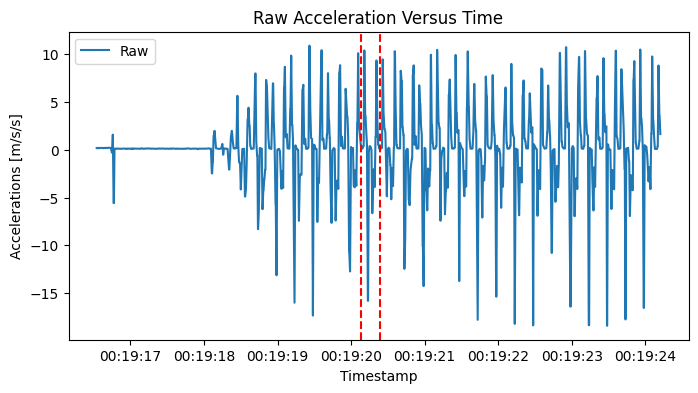

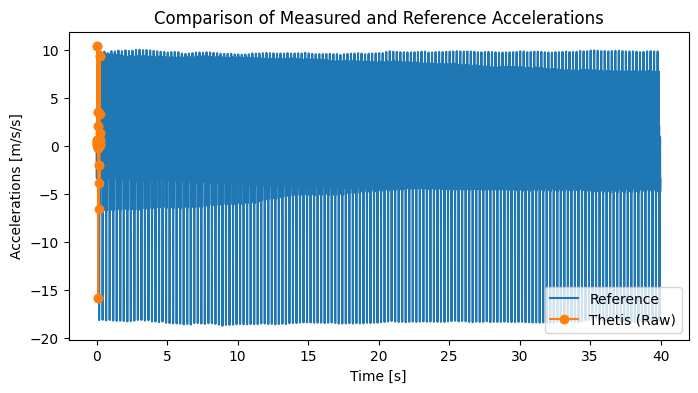

In [23]:
# START_INDEX = 0
START_INDEX = 500
# TIME_WIDTH = len(epoch_data)
TIME_WIDTH = 38
END_INDEX = START_INDEX + TIME_WIDTH

x_meas = epoch_data[START_INDEX:END_INDEX] # Partition examined data into sub array
x_meas = x_meas - x_meas[0] # Zero all the timestamps relative to the first value
x_meas = [x_meas[x].total_seconds() for x in range(np.size(x_meas))] # Convert datetime timestamps to seconds

# Make plots
fig_accel = plt.figure(1, figsize=(8,4))
ax_accel = fig_accel.add_subplot(1,1,1)
ax_accel.set_title("Raw Acceleration Versus Time")
ax_accel.plot(epoch_data, raw_accel_data)
# ax_accel.plot(epoch_data, accel_data)
ax_accel.axvline(epoch_data[START_INDEX], linestyle='--', color='r')
ax_accel.axvline(epoch_data[END_INDEX], linestyle='--', color='r')
ax_accel.set_xlabel("Timestamp")
ax_accel.set_ylabel("Accelerations [m/s/s]")
ax_accel.legend(["Raw"])


fig_comp = plt.figure(2, figsize=(8,4))
ax_comp = fig_comp.add_subplot(1,1,1)
ax_comp.set_title("Comparison of Measured and Reference Accelerations")
ax_comp.plot(df.time[START_INDEX, END_INDEX], df.voltage[START_INDEX, END_INDEX])
ax_comp.plot(x_meas, raw_accel_data[START_INDEX:END_INDEX], 'o-')
ax_comp.set_xlabel("Time [s]")
ax_comp.set_ylabel("Accelerations [m/s/s]")
ax_comp.legend(["Reference", "Thetis (Raw)"])

# ax_scale = fig_comp.add_subplot(1,2,2)
# ax_scale.set_title("Comparison of Measured and Scaled Reference Accelerations")
# ax_scale.plot(x_meas, raw_accel_data[START_INDEX:END_INDEX], 'o-')
# ax_scale.plot(df.time, scope_accel*2.8)
# ax_scale.set_xlabel("Time [s]")
# ax_scale.set_ylabel("Accelerations [m/s/s]")
# ax_scale.legend(["Thetis (Raw)", "Reference (x2.8)"])

N_SAMPLES = len(epoch_data)
T_SAMPLE = np.max(df.time)
F_SAMPLE = len(x_meas) / np.max(x_meas)

print("Number of samples: ", N_SAMPLES) #DEBUG
print("Total Sample Time: ", T_SAMPLE) #DEBUG
print("Average Sample Rate: ", round(F_SAMPLE)) #DEBUG

plt.show()

## Remove High Frequency Noise
There are many sources of High Frequency noise in the test setup. The flexure plates in the vibration table create sources of high frequency interference at low frequencies. Additionally, the table was not rigidly mounted to a weighted base. This caused the table to move introducing more HF noise.

Here, we can design and implement a low-pass Butterworth filter to dampen the noise above a certain a cut-off frequency, $f_c$

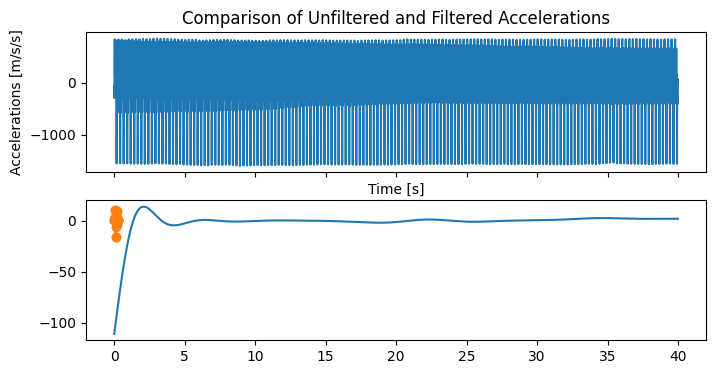

In [21]:
sos = signal.butter(8, 24, 'lp', fs=5E5, output='sos')
filtered = signal.sosfiltfilt(sos, scope_accel)

fig_filt, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax1.set_title("Comparison of Unfiltered and Filtered Accelerations")
ax1.plot(df.time[df.time<0.4], scope_accel[df.time<0.4])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Accelerations [m/s/s]")
ax2.plot(df.time[df.time<0.4], filtered[df.time<0.4])
ax2.plot(x_meas, raw_accel_data[START_INDEX:END_INDEX], 'o-')
# ax_comp.legend(["Reference", "Thetis (Raw)"])

## Run Statistical Analysis
We will experiment with the following procedure:
1. Interpolate the values for each time series along the linear spaced vector, $x_{interp}$. This is done by creating the vector from $[0, max( x_{reference})]$ and running the numpy function, `interp()`.
    - Ex: `scope_accel_interp = np.interp(x_interp, df.time, scope_accel)`
    - Ex: `raw_accel_data_interp = np.interp(x_interp, x_meas, raw_data_accel[START_INDEX:END_INDEX])`
2. Calculate the correlation coefficient between the interpolated time series using numpy's `corrcoef()` function
    - Ex: `corrcoef = np.corrcoef(accel_mat)`
    - Note: `accel_mat` needs to be a 2xN matrix containing the interpolated reference accelerometer measurements and the interpolated Thetis acceleration measurements.

The correlation coefficient calculated by Numpy is the Pearson product-moment correlation coefficient. The returned value from Numpy's `corrcoef()` function is a NxN matrix where each value is bounded from [-1,1]. The closer to 1, the more the data correlates. 

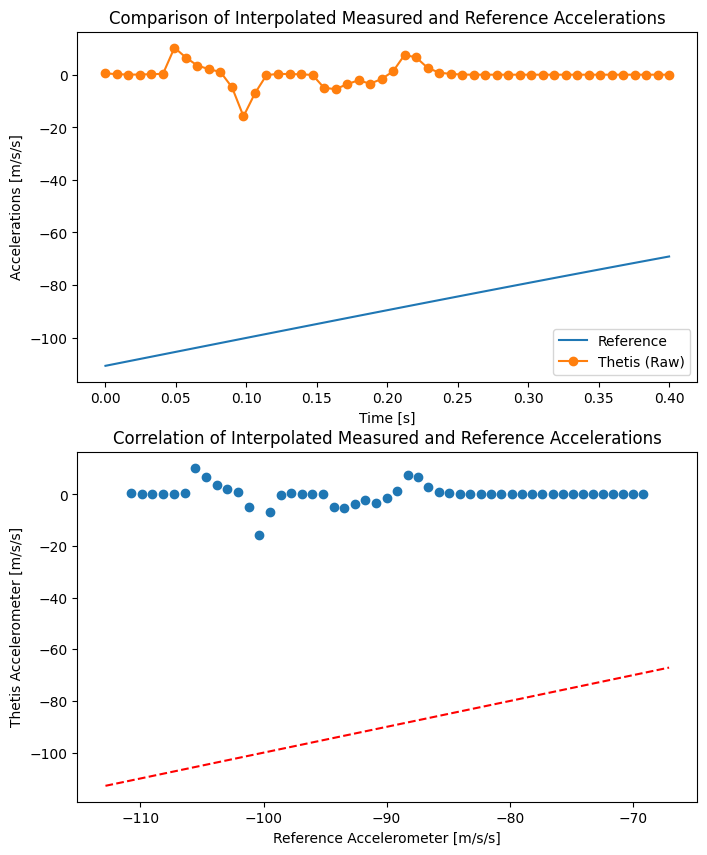

Correlation Coefficient:  0.01


In [22]:
# Create an interpolated time series vector from [0, max(x_ref)] of 50 values
x_interp = np.linspace(0, 0.4, 50)

# Interpolate the different time series
scope_accel_interp = np.interp(x_interp, df.time[df.time<0.4], filtered[df.time<0.4])
raw_accel_data_interp = np.interp(x_interp, x_meas, raw_accel_data[START_INDEX:END_INDEX])
# print(scope_accel_interp)
# print(raw_accel_data_interp)

# Plot interpolated time series
fig_comp_interp = plt.figure(3, figsize=(8,10))
ax_comp_interp = fig_comp_interp.add_subplot(2,1,1)
ax_comp_interp.set_title("Comparison of Interpolated Measured and Reference Accelerations")
ax_comp_interp.plot(x_interp, scope_accel_interp)
ax_comp_interp.plot(x_interp, raw_accel_data_interp, 'o-')
ax_comp_interp.set_xlabel("Time [s]")
ax_comp_interp.set_ylabel("Accelerations [m/s/s]")
ax_comp_interp.legend(["Reference", "Thetis (Raw)"])

ax_corr = fig_comp_interp.add_subplot(2,1,2)
ax_corr.set_title("Correlation of Interpolated Measured and Reference Accelerations")
ax_corr.plot(scope_accel_interp, raw_accel_data_interp, 'o')
x = np.linspace(ax_corr.get_xlim()[0], ax_corr.get_xlim()[1])
ax_corr.plot(x, x, '--', color='red')
ax_corr.set_xlabel("Reference Accelerometer [m/s/s]")
ax_corr.set_ylabel("Thetis Accelerometer [m/s/s]")
plt.show()

# Calculate correlation coefficients
accel_mat = np.array([scope_accel_interp, raw_accel_data_interp])
# print(accel_mat)
corrcoef = np.corrcoef(accel_mat)
print("Correlation Coefficient: ", round(corrcoef[0,1],2))

